In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Add Custom scripts
sys.path.append("./scripts/")
from sc_graph_generator.figure_generator import plot_rna_qc, calculate_descriptive, get_per_sample_stats, multiplets_report

# Load Packages for analyzing sc-rna-seq data
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import scanpy as sc
    import muon as mu

# Load the data files

For this we will be loading the .h5ad, which is an [AnnData](https://anndata.readthedocs.io/en/latest/) object.
- This object will have:
    - **.obs:** this contains information about each cell
    - **.var:** this will be the information about each gene
    - **.X:** the will be .var x .obs matrix where .var = genes and .obs is the cells


#### Loading the AnnData object prioduced by BD pipeline.

In [2]:
# Change this to filepath location
adata_file_path = "../data/gex/copied-FASTQs-expected-cells-30K-v2-rerun-MC.h5ad"
features_path = "../data/gex/features.tsv"


# This will let us know, which are ADT or Gene Expression
features = pd.read_csv(features_path, sep="\t", index_col=0)
features.columns = features.columns.str.replace(" ", "_")
features.index.name = None

# Load Adata
adata = sc.read_h5ad(adata_file_path)
adata.var = adata.var.join(features["Gene_Expression"])

#### Add Meta data to the adata obj

In [3]:
meta_file_path = "../data/meta_data.xlsx"
meta_df = pd.read_excel(meta_file_path)
meta_df = meta_df[meta_df["cartridge"] == "C"]
# Dropping columns that we don't need for the analysis
meta_df.drop(meta_df.columns[4:9], axis=1, inplace=True)
meta_df.rename(columns={"Sample Tags": "Sample_Tag"}, inplace=True)

# Combine the Meta data with the Adata object
df = pd.merge(
    left=adata.obs, 
    right=meta_df, 
    on="Sample_Tag", 
    how="left",
)

df.set_index(adata.obs.index, inplace=True)
adata.obs = df

### Split Gene Expression Data and ADT data

In [4]:
gex_bool = adata.var["Gene_Expression"] == "Gene Expression"
adt_bool = adata.var["Gene_Expression"] == "Antibody Capture"
# Split them
adata_gex = adata[:, gex_bool].copy()
adata_adt = adata[:, adt_bool].copy()

In [5]:
print(f"There were {adata_gex.n_obs} cells and {adata_gex.n_vars} of genes.")
print(f"There were {adata_adt.n_vars} ADT")

There were 19147 cells and 36909 of genes.
There were 21 ADT


## QC Steps for RNA

### Removing Multiplets and Singlets

In [6]:
unkown_multi_cells = adata_gex.obs["Sample_Tag"].isin(["Undetermined", "Multiplet"])
adata_gex = adata_gex[~unkown_multi_cells,]
print(f"Removed {unkown_multi_cells.sum()} cells.")
print(f"{adata_gex.n_obs} cells remain.")

Removed 6181 cells.
12966 cells remain.


#### calculate the QC covariates or metric.
- Mitochondrial Genes
- Ribosomal Genes
- Hemoglobin Genes

In [7]:
# mitochondrial genes
adata_gex.var["mt"] = adata_gex.var_names.str.startswith("MT-")
# ribosomal genes
adata_gex.var["ribo"] = adata_gex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_gex.var["hb"] = adata_gex.var_names.str.contains(("^HB[^(P)]"))

/var/folders/xz/k3tl_sxx7r7_7sftwwwf_v1m0000gq/T/ipykernel_84483/3962754324.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_gex.var["mt"] = adata_gex.var_names.str.startswith("MT-")


In [8]:
sc.pp.calculate_qc_metrics(
    adata_gex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
# mitochondrial genes
adata_gex.var["mt"] = adata_gex.var_names.str.startswith("MT-")
# ribosomal genes
adata_gex.var["ribo"] = adata_gex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_gex.var["hb"] = adata_gex.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    adata_gex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [10]:
# nmads= 8
# # res = np.median(adata_gex.obs.log1p_n_genes_by_counts) + nmads * mad(adata_gex.obs.log1p_n_genes_by_counts)
# res = np.median(adata_gex.obs.log1p_total_counts) + nmads * mad(adata_gex.obs.log1p_total_counts)
# np.expm1(res)

# plt.hist(adata_gex.obs.pct_counts_in_top_20_genes)

### Plot Covarities

### Setting Thresholds for Covarities

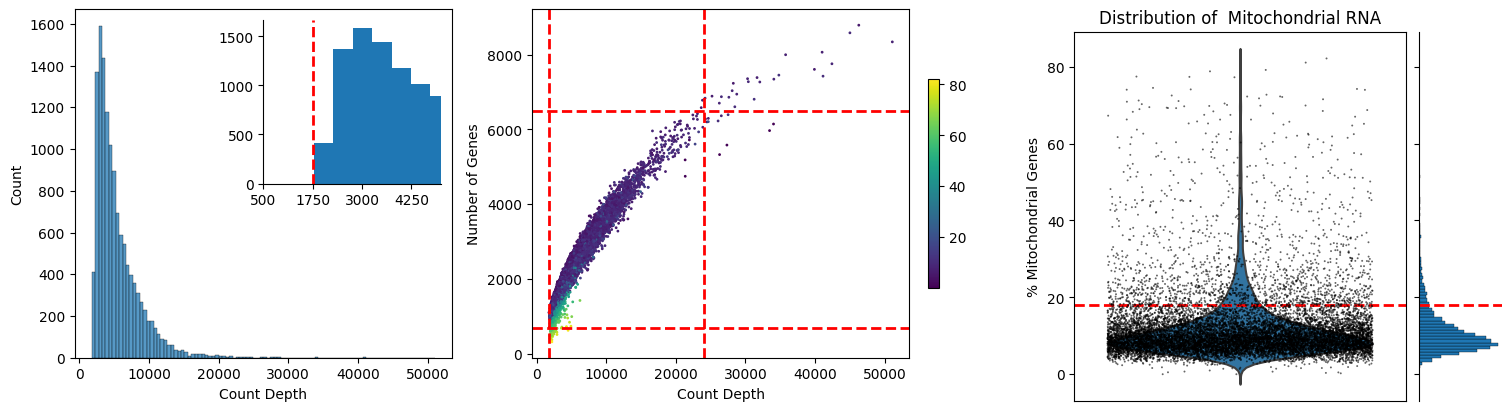

In [11]:
# Set adjust these accordingly.
outliers = {
    "pct_counts_mt": 18,
    "total_counts_low": 1750,
    "total_counts_high": 24000,
    "n_genes_by_counts_low": 700,
    "n_genes_by_counts_high": 6500
}

fig = plot_rna_qc(adata_gex, 
                  # show_jitter=False, 
                  zoom=(500, 5000), 
                  zoom_bins=100
                 )

axs = fig.get_axes()

for item in axs[0].get_children():
    if isinstance(item, plt.Axes):
        item.axvline(x=outliers["total_counts_low"], color="red", ls="--", lw=2)

# cut off for sequencing
axs[1].axvline(x=outliers["total_counts_low"], color="red", ls="--", lw=2)
axs[1].axvline(x=outliers["total_counts_high"], color="red", ls="--", lw=2)


# Cut off for n_genes
axs[1].axhline(y=outliers["n_genes_by_counts_low"], color="red", ls="--", lw=2)
axs[1].axhline(y=outliers["n_genes_by_counts_high"], color="red", ls="--", lw=2)


# Set to zoom in
# axs[1].set_xlim(0, 625)

# Cut off for PCT 
axs[3].axhline(y=outliers["pct_counts_mt"], color="red", ls="--", lw=2)
axs[4].axhline(y=outliers["pct_counts_mt"], color="red", ls="--", lw=2)

In [12]:
get_per_sample_stats(adata=adata_gex, mt_threshold=outliers["pct_counts_mt"], samples_col="Sample_Tag")

,Mean % MT Per Cell,Mean # Reads Per Cell,Mean # Gene Per Cell,Cells Pass 18% Threshold,Cell Count,Read Depth
Sample_Tag,,,,,,
SampleTag01_hs,9.325590,3509.504472,1775.561717,95.35%,559,1961813
SampleTag02_hs,12.300701,7070.301389,2778.811111,85.56%,720,5090617
SampleTag03_hs,16.002729,6256.150396,2563.097625,74.67%,1137,7113243
SampleTag04_hs,12.466609,5815.633588,2442.750273,91.17%,917,5332936
SampleTag05_hs,10.748899,3516.275000,1739.707500,94.00%,400,1406510
SampleTag06_hs,15.169383,6607.202041,2542.109524,74.90%,1470,9712587
SampleTag07_hs,12.469478,5969.258065,2539.288387,85.61%,1550,9252350
SampleTag08_hs,13.441168,4757.604376,2065.003646,82.77%,1097,5219092
SampleTag09_hs,8.415857,3497.951592,1753.282803,98.73%,1570,5491784


# Remove Unknown, Multiplets and poor quality reads based on covarities

### Remove Dead or Dying Cells

In [13]:
filter_mt = adata_gex.obs["pct_counts_mt"] <= outliers["pct_counts_mt"]
filter_counts = adata_gex.obs["total_counts"].between(outliers["total_counts_low"], outliers["total_counts_high"])
filter_n_genes =  adata_gex.obs["n_genes_by_counts"].between(outliers["n_genes_by_counts_low"], outliers["n_genes_by_counts_high"])

# Filter cells on all three covarities
# adata_gex = adata_gex[filter_mt &  filter_counts & filter_n_genes]
health_bool = (filter_counts | filter_n_genes) & filter_mt
pct_pass = health_bool.sum() / len(adata_gex) 
print(f"{round(pct_pass, 4) * 100}% ({health_bool.sum()} total cells) Living Cells.")

87.0% (11280 total cells) Living Cells.


In [14]:
adata_gex = adata_gex[health_bool, ]

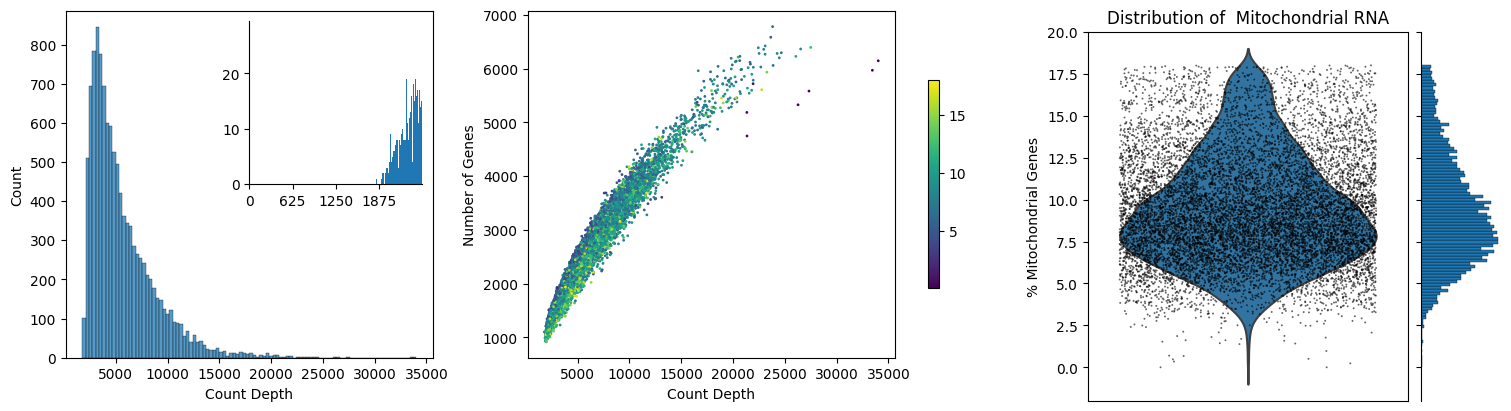

In [15]:
fig = plot_rna_qc(adata_gex, 
                  # show_jitter=False, 
                  zoom=(0, 2500), 
                  zoom_bins=5000
                 )

In [16]:
print(f"Total remaining cells {adata_gex.n_obs}")

Total remaining cells 11280


## Remove Doublets and Correct for Ambient RNA
To remove doublets run each code block in the R markdown `../r_notebooks/dbltFinder.Rmd`. 
- Before running the R markdown be sure to run the next line of code titled, Export Sparse Matrix For R.

In [17]:
import os
import scipy.io as sio 

### Export Sparse Matrix for R

In [18]:
def adata_to_mtx(adata, dir_path):
    try:
        mtx = adata.X.T
        # dir to save files.
        tmp_path = os.path.join(dir_path, "tmp")
    
        # File paths for features, obs and mtx
        barcode_path = os.path.join(tmp_path, "barcodes.tsv")
        feature_path = os.path.join(tmp_path, "features.tsv")
        mtx_path =os.path.join(tmp_path, "sparse_matrix.mtx")
       
        if "tmp" not in os.listdir(dir_path):
            os.mkdir(tmp_path)
            
        with open(barcode_path, "w") as f:
            barcodes = "\n".join(list(adata.obs_names))
            f.writelines(barcodes)
        
        with open(feature_path, "w") as f:
            var_names = "\n".join(list(adata.var_names))
            f.writelines(var_names)
        sio.mmwrite(mtx_path, mtx)
        print(f"File saved to {tmp_path}")
        
    except Exception as err:
        print(err)
        print("Failed to export data")

In [19]:
adata_to_mtx(adata_gex, dir_path="../data/")

File saved to ../data/tmp


### Load Doublet Detection Results

In [20]:
from IPython.display import display, Javascript

In [21]:
try:
    # Load doublet resutls and replce "." with "_" in the column names.
    dblt_finders = pd.read_csv("../data/tmp/dblt_scores.csv", index_col=0)
    dblt_finders.columns = dblt_finders.columns.str.replace(".", "_")
    
    # This allows us to see float points at higher precision
    pd.options.display.float_format = None
    
    # Need to convert index to str
    dblt_finders.index = dblt_finders.index.astype(str)
    adata_gex.obs.index = adata_gex.obs.index.astype(str)
    adata_gex.obs = adata_gex.obs.join(dblt_finders)
except FileNotFoundError:
    message = "You need to run the R markdown dbltFinder.Rmd script first if you want include doublet classification and then rerun this chunk"
    display(Javascript(f"alert('{message}')"))

In [22]:
dblt_finders

,doublet_class,doublet_score
57,singlet,0.064285
408,singlet,0.000366
461,doublet,0.844290
467,singlet,0.000128
860,doublet,0.686373
...,...,...
14042536,singlet,0.051966
14042585,singlet,0.000340
14044069,singlet,0.005532
14044456,singlet,0.067524


In [23]:
singlets, doublets = adata_gex.obs.doublet_class.value_counts()
pct_dblts = round(doublets / (singlets + doublets), 4) * 100
print(f"The pct of potential doubles {pct_dblts}% ({doublets} total) found.")

The pct of potential doubles 5.4% (609 total) found.


# Normalize the Data

**Purpose**
In scRNA-seq (single-cell RNA sequencing), the objective is to analyze the transcriptomes of individual cells to understand their unique profiles. However, due to technical and biological variances, the raw data can be noisy and may not reflect the true underlying biological signal. We normalize raw count data to account for these variabilities.


In [24]:
from scipy.sparse import issparse

### Shifted Algorithm
Used to stabilize the variances across a scRNA-seq dataset by adjusting the raw counts, considering size factors and pseudo-counts. This method is particularly beneficial for addressing overdispersion.
- well-suited for further **dimensionality reduction** and identification of differentially expressed genes. 

In [25]:
# normalizes the total counts in each cell. 
#The idea behind this is to make the total counts (or reads) from each cell comparable by scaling them.
scale_counts = sc.pp.normalize_total(adata_gex, 
                                     # normalizes each cell's total count to match the median of the total counts across all cells
                                     target_sum=None, 
                                     inplace=False)

# Helps reduce impacts of noise and helps with down-stream analyses (many test assume homoscedascity and normal distribution) 
adata_gex.layers["log1p_norm"] = sc.pp.log1p(scale_counts["X"], copy=True)

In [26]:
from scipy.stats import median_abs_deviation as mad

#### Comparing Before and After log1p

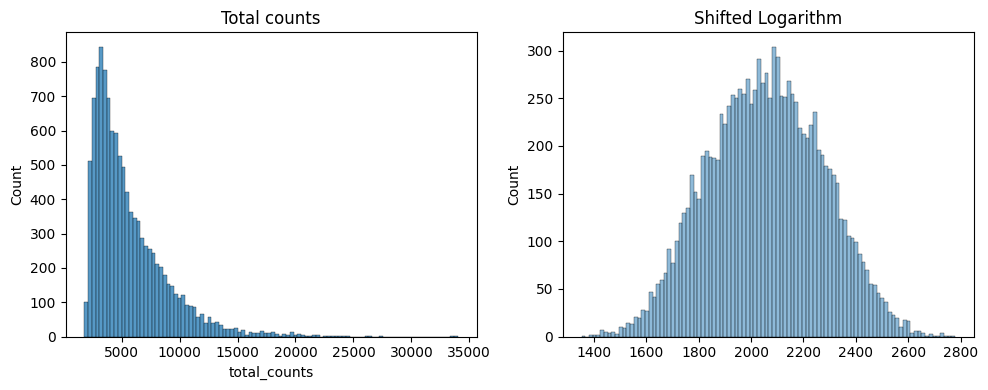

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

# Before log1p Transform
sns.histplot(adata_gex.obs["total_counts"], ax=axs[0], bins=100)
axs[0].set_title("Total counts");


# After log1p transform
sns.histplot(adata_gex.layers["log1p_norm"].sum(1), ax=axs[1], legend=None, bins=100)
axs[1].set_title("Shifted Logarithm");

fig.tight_layout()

### Scran Based Algorithm
Similar to the shifted logarithm, it uses raw counts, a size factor, and a pseudo-count in its calculations. Unlike the shifted logarithm, Scran employs a deconvolution approach, estimating size factors through linear regression over genes for pools of cells, aiming for better count depth variation accounting across all cells.

- method was **well-tested for batch correction tasks** and can be utilized via its R package.

#### Preliminary clustering for differentiated normalisation
- scran requires a coarse clustering input to improve size factor esimation performance.

## Save QC Results

In [28]:
filename = "121c_quality_control.h5ad"

if "qc_data" not in os.listdir("../data"):
    os.mkdir("../data/qc_data")

save_file_path = f"../data/qc_data/{filename}"

adata_gex.obs.day = adata_gex.obs.day.astype(str)
adata_gex.obs["date"] = adata_gex.obs["date"].astype(str)
adata_gex.write(save_file_path)

# Save ADT in Raw Folder

In [29]:
filename = "121c_ADT_raw.h5ad"
save_file_path = f"../data/gex/{filename}"
adata_adt.obs.day = adata_adt.obs.day.astype(str)
adata_adt.obs["date"] = adata_adt.obs["date"].astype(str)
adata_adt.write(save_file_path)